# Relax Case Study- Interview Challenge

## Part 1 - Exploratory Data Analysis
The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

The analysis:  
1) Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.  

2) Report/illustrate important features of the demand, such as daily cycles. 

3) Identify any data quality issues

This is a practice take home challenge from Relax Inc.

The data is available as two attached CSV files: takehome_user_engagement. csv takehome_users . csv The data has the following two tables:

1)  user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:

-name: the user's name

-object_id: the user's id

-email: email address

-creation_source: how their account was created. This takes on one of 5 values:

-PERSONAL_PROJECTS: invited to join another user's personal workspace

-GUEST_INVITE: invited to an organization as a guest (limited permissions)

-ORG_INVITE: invited to an organization (as a full member)

-SIGNUP: signed up via the website

-SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

-creation_time: when they created their account

-last_session_creation_time: unix timestamp of last login

-opted_in_to_mailing_list: whether they have opted into receiving marketing emails

-enabled_for_marketing_drip: whether they are on the regular marketing email drip

-org_id: the organization (group of users) they belong to

-invited_by_user_id: which user invited them to join (if applicable).


2)usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption .

## Sourcing and Loading

### Load relevant libraries 

In [1]:
import json
import itertools
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter 
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Set the style to "darkgrid"
sns.set_style('darkgrid')
sns.set_palette(["#39A7D0","#36ADA4"])

### Load the data

In [2]:
# Read in users file
users = pd.read_csv("data/takehome_users.csv", parse_dates=True)
print(users.shape)
print(users.columns)
users.head()

(12000, 10)
Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# Rename column object_id to user_id to align with other table
users = users.rename(columns={'object_id': 'user_id'})
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/14 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/13 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/13 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/13 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/13 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# Read in engagement file
engagement = pd.read_csv("data/takehome_user_engagement.csv", parse_dates=True)
print(engagement.shape)
print(engagement.columns)
engagement.head()

(207917, 3)
Index(['time_stamp', 'user_id', 'visited'], dtype='object')


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [5]:
# Look at data types for users
users.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [6]:
# make sure datatime value are correct type for users
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [7]:
# Look at data types for engagement
engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [8]:
# make sure datatime value and set the index
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement = engagement.set_index('time_stamp')

#pd.to_datetime
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [9]:
# Look at duration of data
print("Start of data",min(engagement.index))
print("End of data",max(engagement.index))
print('Duration of data: ',engagement.index.max()-engagement.index.min(),'\n')
# We can see that the data is over 736 days in 2012-2014

Start of data 2012-05-31 08:20:06
End of data 2014-06-06 14:58:50
Duration of data:  736 days 06:38:44 



In [10]:
engagement['user_id'].describe()
# Shows 12,000 user numbers who access the system a total of 207917 times

count    207917.000000
mean       5913.314197
std        3394.941674
min           1.000000
25%        3087.000000
50%        5682.000000
75%        8944.000000
max       12000.000000
Name: user_id, dtype: float64

In [11]:
# Look at the data for a single user
# pick user 10
user_10 = engagement[engagement['user_id'] == 10]
user_10['visited'].describe()
# All visited values are either 1, only entries for each visit
# We can use this to sum event counts

count    284.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: visited, dtype: float64

In [12]:
# Set invited_by_user_id to integer
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period

## Set ADOPTED Label

In [13]:
from datetime import timedelta

def feature_adopted(u_id):    
#takes a users from dataframe and returns adopted - More than 3 logins in any 7-day period
    per = 7                                               # Period is 7 days
    df = engagement.loc[engagement['user_id'] == u_id]    # Select this user
    df = df.resample('D').mean().dropna()                 # Resample 
    adopted = 0
    for i in range(len(df)-2):                       #loop over active days till the second to last day
        if df.index[i + 2] - df.index[i] <= timedelta(days=per): # if gap between 3 logins less than period
            adopted = 1
            break
        else: adopted = 0
    return adopted

In [14]:
# Add label to users if adopted=true 
users['adopted'] = users['user_id'].apply(feature_adopted)
print(users.shape)
users.head()

(12000, 11)


,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525,0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151,0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240,0


In [15]:
print('Count of Adopted Users: ',sum(users['adopted']))
print('Percentage of Adopted Users: ',sum(users.adopted)/len(users.adopted)*100)

Count of Adopted Users:  1656
Percentage of Adopted Users:  13.8


# Set use_duration feature

In [16]:
# create a feature of user duration
# convert both time features into datetime
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [17]:
# calculate use_duration, defined as number of days between account creation and last use
users['use_duration'] = users['last_session_creation_time'] - users['creation_time']
users['use_duration'] = users['use_duration'].dt.days

In [18]:
# calculate account age, defined as number of days since account creation and latest creation time
latest = max(users['creation_time'])
users['accnt_age'] = latest - users['creation_time']
users['accnt_age'] = users['accnt_age'].dt.days
# drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [19]:
users.head()

,user_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,use_duration,accnt_age
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,0,0.0,38
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,1,136.0,196
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,0,0.0,437
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,0,1.0,374
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,0,5.0,498


## Establish Total Visit Counts per User

In [20]:
# group by user id, and greate a 'total_visits' feature
visits_by_users = engagement.groupby('user_id').sum()
visits_by_users = visits_by_users.rename(columns={'visited': 'total_visits'})
visits_by_users.head(15)

,total_visits
user_id,
1,1
2,14
3,1
4,1
5,1
6,1
7,1
10,284
11,1


In [21]:
# Add Total_Visit counts to users by merging df to existing
users = users.merge(visits_by_users, how='left', on='user_id')
users['total_visits'] = users['total_visits'].fillna(0)
users['total_visits'] = users['total_visits'].astype(int)
print(users.shape)
users.head(15)

(12000, 12)


,user_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,use_duration,accnt_age,total_visits
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,0,0.0,38,1
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,1,136.0,196,14
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,0,0.0,437,1
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,0,1.0,374,1
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,0,5.0,498,1
5,6,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,0,0,197,11241,0,2.0,164,1
6,7,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,0,1,37,0,0,4.0,530,1
7,8,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1,1,74,0,0,NaN,303,0
8,9,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0,0,302,0,0,NaN,206,0
9,10,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1,1,318,4143,1,503.0,499,284


In [22]:
# Replace any NaN values with zero
users['total_visits'] = users['total_visits'].fillna(0)

# Establish Email Provider label

In [23]:
# Split email provider on provider name
users['email_provider'] = [x.split('@')[1] for x in users.email] 
# Just look at top 5
top_emails = users.email_provider.value_counts().index[:6]
#label anything not in the top 5 as other
users['email_provider'] = [x if x in top_emails else 'other' for x in users.email_provider]

In [24]:
# Remove NaN from when Not Invited by User
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

In [25]:
users.head(15)

,user_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,use_duration,accnt_age,total_visits,email_provider
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,0,0.0,38,1,yahoo.com
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,1,136.0,196,14,gustr.com
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,0,0.0,437,1,gustr.com
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,0,1.0,374,1,yahoo.com
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,0,5.0,498,1,yahoo.com
5,6,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,0,0,197,11241,0,2.0,164,1,yahoo.com
6,7,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,0,1,37,0,0,4.0,530,1,jourrapide.com
7,8,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1,1,74,0,0,NaN,303,0,yahoo.com
8,9,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0,0,302,0,0,NaN,206,0,hotmail.com
9,10,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1,1,318,4143,1,503.0,499,284,gustr.com


# Prep for Model

In [27]:
# Set up df only for needed columns for model
udf = users.drop(['name', 'email'], axis=1)
udf.head()

,user_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,use_duration,accnt_age,total_visits,email_provider
0,1,GUEST_INVITE,1,0,11,10803,0,0.0,38,1,yahoo.com
1,2,ORG_INVITE,0,0,1,316,1,136.0,196,14,gustr.com
2,3,ORG_INVITE,0,0,94,1525,0,0.0,437,1,gustr.com
3,4,GUEST_INVITE,0,0,1,5151,0,1.0,374,1,yahoo.com
4,5,GUEST_INVITE,0,0,193,5240,0,5.0,498,1,yahoo.com


In [31]:
# Last check for Nan values
udf.isnull().sum()

user_id                          0
creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
adopted                          0
use_duration                  3177
accnt_age                        0
total_visits                     0
email_provider                   0
dtype: int64

In [32]:
# resolve all use_durations to zero for nulls
udf['use_duration'] = udf['use_duration'].fillna(0)
udf.isnull().sum()

user_id                       0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted                       0
use_duration                  0
accnt_age                     0
total_visits                  0
email_provider                0
dtype: int64

In [33]:
# Set encoding on creation_source and email_provider
# generate binary values using get_dummies
users_df = pd.get_dummies(udf, columns=["creation_source","email_provider"])
users_df.head()

,user_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,use_duration,accnt_age,total_visits,creation_source_GUEST_INVITE,...,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_provider_cuvox.de,email_provider_gmail.com,email_provider_gustr.com,email_provider_hotmail.com,email_provider_jourrapide.com,email_provider_other,email_provider_yahoo.com
0,1,1,0,11,10803,0,0.0,38,1,1,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,1,316,1,136.0,196,14,0,...,0,0,0,0,0,1,0,0,0,0
2,3,0,0,94,1525,0,0.0,437,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0,1,5151,0,1.0,374,1,1,...,0,0,0,0,0,0,0,0,0,1
4,5,0,0,193,5240,0,5.0,498,1,1,...,0,0,0,0,0,0,0,0,0,1


In [34]:
# Apply Random Forrest model based on small numbers and mix of categorical and measure values
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
data = users_df.drop('adopted', axis=1)
labels = users_df.adopted

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.25, random_state=23)

In [35]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')
rf.fit(X_train, X_test)
rf.score(y_train, y_test)

0.984

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2587
           1       0.96      0.92      0.94       413

    accuracy                           0.98      3000
   macro avg       0.97      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000

confusion matrix:
[[2570   17]
 [  31  382]]


# Feature Importance

In [37]:
# Organize the cofficients by feature name
features = pd.DataFrame()
features['coef'] = rf.feature_importances_
features = features.set_index(data.columns)
features.coef.nlargest(15)

total_visits                          0.582610
use_duration                          0.343913
accnt_age                             0.022691
org_id                                0.015321
user_id                               0.010631
invited_by_user_id                    0.006423
creation_source_PERSONAL_PROJECTS     0.003195
email_provider_gmail.com              0.002083
creation_source_GUEST_INVITE          0.001882
opted_in_to_mailing_list              0.001297
enabled_for_marketing_drip            0.001225
creation_source_SIGNUP                0.001212
email_provider_yahoo.com              0.001165
creation_source_SIGNUP_GOOGLE_AUTH    0.001071
creation_source_ORG_INVITE            0.000990
Name: coef, dtype: float64

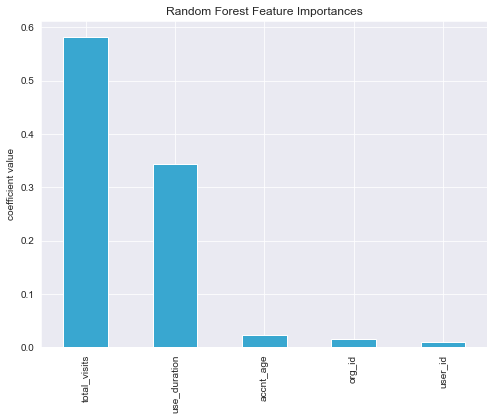

In [39]:
# Looks like only the top 5 have impact
import matplotlib.pyplot as plt
#plot the results

plt.figure(figsize=(8,6))
(features['coef']).nlargest(5).plot(kind='bar', x=features.index)
plt.title('Random Forest Feature Importances')
plt.ylabel('coefficient value')
plt.show()


In [40]:
# Set up ecdf method to plot results
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

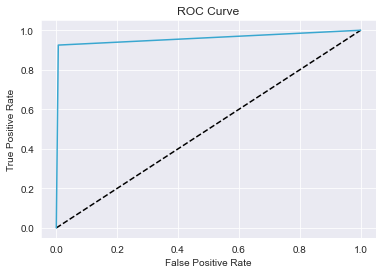

In [44]:
# plot ROC curve from values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

From the model output, we see with 98.4% accuracy that the top 5 features of total_visits, use_duration, accnt_age predit the result of adoption. The recall and precision were both at 98%.  The factors of total_visits and use_duration appear correlated. 